# CIFAR10 Conv Autoencoder

In [1]:
import os
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import warnings
import time
import cPickle
warnings.filterwarnings("ignore", category=DeprecationWarning)  ## just for ignore DeprcationWarning message
print("Current version [%s]" %(tf.__version__))
print("Packages Loaded")

Current version [1.3.0]
Packages Loaded


### Configurations

In [2]:
# Dataset Configurations
tf.app.flags.DEFINE_integer('img_size', 32, """Image size of CIFAR-10 dataset""")
tf.app.flags.DEFINE_integer('img_num', 10000, """Number of images in one cifar batch""")
tf.app.flags.DEFINE_integer('batch_num', 5, """Number of cifar batches in dataset""")
tf.app.flags.DEFINE_string('train_dir', './../../../Dataset/cifar-10-batches-py', """Directory which contains the train data""")
tf.app.flags.DEFINE_string('test_dir', './../../../Dataset/cifar-10-batches-py', """Directory which contains the test data""")

# Network Configurations
tf.app.flags.DEFINE_integer('batch_size', 100, """Number of images to process in a batch""")
tf.app.flags.DEFINE_float('l1_ratio', 0.5, """Ratio of level1""")
tf.app.flags.DEFINE_float('l2_ratio', 0.5, """Ratio of level2""")

# Optimization Configurations
tf.app.flags.DEFINE_float('lr', 0.001, """Learning rate""")

# Training Configurations
tf.app.flags.DEFINE_integer('training_epochs', 500, """Number of epochs to run""")
tf.app.flags.DEFINE_integer('display_step', 5, """Number of iterations to display training output""")
tf.app.flags.DEFINE_integer('save_step', 20, """Number of interations to save checkpoint""")
tf.app.flags.DEFINE_integer('save_max', 10, """Number of checkpoints to remain""")


# Save Configurations
tf.app.flags.DEFINE_string('nets', './nets', """Directory where to write the checkpoints""")
tf.app.flags.DEFINE_string('outputs', './outputs', """Directory where to save the output images""")
tf.app.flags.DEFINE_string('tboard', './tensorboard', """Directory where to save the tensorboard logs""")


FLAGS = tf.app.flags.FLAGS
print("FLAGS READY")

FLAGS READY


### GPU control

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3

### Load Data

In [4]:
def unpickle(file):
    with tf.device('/CPU:0'):
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict

def read_cifar(file):
    with tf.device('/CPU:0'):
        _dic = unpickle(file)
        _img = _dic['data']/255.    # float type
        _label = _dic['labels']    # (10000, )

#         _img_shape = np.shape(_img)
#         _img = np.reshape(np.transpose(np.reshape(_img, (-1, 3, 32, 32)), (0,2,3,1)), _img_shape) # (10000, 3072)

        _img = np.transpose(np.reshape(_img, (-1, 3, 32, 32)), (0,2,3,1))
    
        return _img   # (10000, 32, 32, 3)
   

### Generating random noise mask

In [5]:
def noise_mask(prob=0.5):
    mask = np.zeros([FLAGS.img_size, FLAGS.img_size, 3])
    rd = np.random.random()
    if rd > prob:
        # threshold of the size of masks
        uthd = FLAGS.img_size    
        lthd = 0     
        # mask size should be beween 14x14, 5x5
        while(uthd>14 or lthd<5):
            ver1 = np.random.random_integers(0, FLAGS.img_size-1, size= 2)   # vertex1
            ver2 = np.random.random_integers(0, FLAGS.img_size-1, size= 2)    # vertex2
            uthd = np.maximum(np.abs(ver1[0]-ver2[0]), np.abs(ver1[1]-ver2[1]))    # upperbound
            lthd = np.minimum(np.abs(ver1[0]-ver2[0]), np.abs(ver1[1]-ver2[1]))    # lowerbound
        xmin = np.minimum(ver1[0], ver2[0])    # left x value
        xmax = np.maximum(ver1[0], ver2[0])    # right x value
        ymin = np.minimum(ver1[1], ver2[1])    # top y value
        ymax = np.maximum(ver1[1], ver2[1])    # bottom y value
        noise = np.random.random((xmax-xmin+1, ymax-ymin+1, 3))    # random sample in [0,1]
        mask[xmin:xmax+1, ymin:ymax+1, :] = noise    # noise mask with location
        mask_meta = [xmin, xmax, ymin, ymax, noise, mask]
#         mask = np.reshape(mask, [-1])
    return mask

def noise_batch(batch_num):
    # make random noise batch
    mask_batch = np.zeros([batch_num, FLAGS.img_size, FLAGS.img_size, 3])
    for i in range(batch_num):
        mask_batch[i] = noise_mask()
    return mask_batch


def occl(target, disturb):
    # Occlusion generation
    mask = (disturb==0).astype(float)
    masked_target = np.multiply(target, mask)
    crpt = np.add(masked_target, disturb)
    return crpt

### Nested Convolutional Encoder

In [6]:
def _nested_enc(l1, l2_s, l2, out_channel, name, filter_size=3, std=[1,2,2,1],pad='SAME', stddev=0.1):
    l1_shape = l1.get_shape()
    l2_shape = l2.get_shape()
    l2_s_shape = l2_s.get_shape()
                                   
    #with tf.device('/CPU:0'):
    with tf.variable_scope('level1'):
        with tf.variable_scope(name):
            l1_weights = tf.get_variable('weights', 
                                         [filter_size, filter_size, l1_shape[3], out_channel*FLAGS.l1_ratio], 
                                         tf.float32, 
                                         initializer=tf.random_normal_initializer(stddev=stddev))
            l1_biases = tf.get_variable('biases', 
                                        [out_channel*FLAGS.l1_ratio],
                                        tf.float32, 
                                        initializer=tf.random_normal_initializer(stddev=stddev))
    with tf.variable_scope('level2'):
        with tf.variable_scope(name):
            l2_s_weights = tf.get_variable('weights_shell', 
                                           [filter_size, filter_size, l2_s_shape[3], out_channel*FLAGS.l2_ratio], 
                                           tf.float32, 
                                           initializer=tf.random_normal_initializer(stddev=stddev))
            l2_s_biases = tf.get_variable('biases_shell', 
                                          [out_channel*FLAGS.l2_ratio],
                                          tf.float32, 
                                          initializer=tf.random_normal_initializer(stddev=stddev))
            l2_weights_1to2 = tf.get_variable('weights_1to2', 
                                           [filter_size, filter_size, l1_shape[3], out_channel*FLAGS.l2_ratio], 
                                           tf.float32, 
                                           initializer=tf.random_normal_initializer(stddev=stddev))
            l2_weights_2to1 = tf.get_variable('weights_2to1', 
                                           [filter_size, filter_size, l2_s_shape[3], out_channel*FLAGS.l1_ratio], 
                                           tf.float32, 
                                           initializer=tf.random_normal_initializer(stddev=stddev))

    l1_conv = tf.nn.conv2d(l1, l1_weights, strides=std, padding=pad)
    l1_act = tf.nn.sigmoid(tf.add(l1_conv, l1_biases))

    l2_s_conv = tf.nn.conv2d(l2_s, l2_s_weights, strides=std, padding=pad)
    l2_s_act = tf.nn.sigmoid(tf.add(l2_s_conv, l2_s_biases))

    l2_conv_1to1 = tf.nn.conv2d(l2[:,:,:,:l1_shape[3]], l1_weights, strides=std, padding=pad)
    l2_conv_2to1 = tf.nn.conv2d(l2[:,:,:,l1_shape[3]:l2_shape[3]], l2_weights_2to1, strides=std, padding=pad)
    l2_act_1 = tf.nn.sigmoid(tf.add(tf.add(l2_conv_1to1, l2_conv_2to1), l1_biases))
    l2_conv_1to2 = tf.nn.conv2d(l2[:,:,:,:l1_shape[3]], l2_weights_1to2, strides=std, padding=pad)
    l2_conv_2to2 = tf.nn.conv2d(l2[:,:,:,l1_shape[3]:l2_shape[3]], l2_s_weights, strides=std, padding=pad)
    l2_act_2 = tf.nn.sigmoid(tf.add(tf.add(l2_conv_1to2, l2_conv_2to2), l2_s_biases))
    l2_act = tf.concat((l2_act_1, l2_act_2), 3)
        
        
    return l1_act, l2_s_act, l2_act

def _nested_enc_init(_img, out_channel, name, filter_size=3, std=[1,2,2,1],pad='SAME', stddev=0.1):
    # input is the input image 
    
    #with tf.device('/CPU:0'):
    with tf.variable_scope('level1'):
        with tf.variable_scope(name):
            l1_weights = tf.get_variable('weights', 
                                         [filter_size, filter_size, 3, out_channel*FLAGS.l1_ratio], 
                                         tf.float32, 
                                         initializer=tf.random_normal_initializer(stddev=stddev))
            l1_biases = tf.get_variable('biases', 
                                        [out_channel*FLAGS.l1_ratio],
                                        tf.float32, 
                                        initializer=tf.random_normal_initializer(stddev=stddev))
    with tf.variable_scope('level2'):
        with tf.variable_scope(name):
            l2_s_weights = tf.get_variable('weights_shell', 
                                         [filter_size, filter_size, 3, out_channel*FLAGS.l2_ratio], 
                                         tf.float32, 
                                         initializer=tf.random_normal_initializer(stddev=stddev))
            l2_s_biases = tf.get_variable('biases_shell', 
                                        [out_channel*FLAGS.l2_ratio],
                                        tf.float32, 
                                        initializer=tf.random_normal_initializer(stddev=stddev))

#     _input_img = tf.reshape(_img, [-1, FLAGS.img_size, FLAGS.img_size, 3])
    l1_conv = tf.nn.conv2d(_img, l1_weights, strides=std, padding=pad)
    l1_act = tf.nn.sigmoid(tf.add(l1_conv, l1_biases))
    l2_s_conv = tf.nn.conv2d(_img, l2_s_weights, strides=std, padding=pad)
    l2_s_act = tf.nn.sigmoid(tf.add(l2_s_conv, l2_s_biases))
    l2_act = tf.concat((l1_act, l2_s_act), 3)
    
    return l1_act, l2_s_act, l2_act

def _nested_enc_last(l1, l2_s, l2, out_channel, name, pad='VALID', stddev=0.1):
    # output is an encoded vector -> Fully convolutioanl layer
    l1_shape = l1.get_shape()    
    l2_shape = l2.get_shape()
    l2_s_shape = l2_s.get_shape()  
    #l1_size = [l1_shape[1], l2_shape[2]]    # l1_shape[1], l1_shape[2] will be used in conv_transpose shape

    #with tf.device('/CPU:0'):
    with tf.variable_scope('level1'):
        with tf.variable_scope(name):
            l1_weights = tf.get_variable('weights', 
                                         [l1_shape[1],l1_shape[2],l1_shape[3], out_channel*FLAGS.l1_ratio], 
                                         tf.float32, 
                                         initializer=tf.random_normal_initializer(stddev=stddev))
            l1_biases = tf.get_variable('biases', 
                                        [out_channel*FLAGS.l1_ratio],
                                        tf.float32, 
                                        initializer=tf.random_normal_initializer(stddev=stddev))
    with tf.variable_scope('level2'):
        with tf.variable_scope(name):
            l2_s_weights = tf.get_variable('weights_shell', 
                                         [l2_s_shape[1],l2_s_shape[2],l2_s_shape[3], out_channel*FLAGS.l2_ratio], 
                                         tf.float32, 
                                         initializer=tf.random_normal_initializer(stddev=stddev))
            l2_s_biases = tf.get_variable('biases_shell', 
                                        [out_channel*FLAGS.l2_ratio],
                                        tf.float32, 
                                        initializer=tf.random_normal_initializer(stddev=stddev))

    l1_conv = tf.nn.conv2d(l1, l1_weights, strides=[1,1,1,1], padding=pad)
    l1_act = tf.nn.sigmoid(tf.add(l1_conv, l1_biases))
    l2_s_conv = tf.nn.conv2d(l2_s, l2_s_weights, strides=[1,1,1,1], padding=pad)
    l2_s_act = tf.nn.sigmoid(tf.add(l2_s_conv, l2_s_biases))
    l2_act = tf.concat((l1_act, l2_s_act), 3)
        
    return l1_act, l2_s_act, l2_act

### Nested Convolutional Decoder

In [7]:
def _nested_dec(l1, l2_s, l2, out_size, out_channel, name, filter_size=3, std=[1,2,2,1], pad='SAME', stddev=0.1):
    l1_shape = l1.get_shape()
    l2_shape = l2.get_shape()
    l2_s_shape = l2_s.get_shape()
    
    
    l1_out_shape = [tf.shape(l1)[0],out_size[0],out_size[1],int(out_channel*FLAGS.l1_ratio)]
    l2_s_out_shape = [tf.shape(l2_s)[0],out_size[0],out_size[1],int(out_channel*FLAGS.l2_ratio)]
    
    #with tf.device('/CPU:0'):
    with tf.variable_scope('level1'):
        with tf.variable_scope(name):
            l1_weights = tf.get_variable('weights', 
                                         [filter_size, filter_size, out_channel*FLAGS.l1_ratio, l1_shape[3]], 
                                         tf.float32, 
                                         initializer=tf.random_normal_initializer(stddev=stddev))
            l1_biases = tf.get_variable('biases', 
                                        [out_channel*FLAGS.l1_ratio],
                                        tf.float32, 
                                        initializer=tf.random_normal_initializer(stddev=stddev))
    with tf.variable_scope('level2'):
        with tf.variable_scope(name):
            l2_s_weights = tf.get_variable('weights_shell', 
                                           [filter_size, filter_size, out_channel*FLAGS.l2_ratio, l2_s_shape[3]], 
                                           tf.float32, 
                                           initializer=tf.random_normal_initializer(stddev=stddev))
            l2_s_biases = tf.get_variable('biases_shell', 
                                          [out_channel*FLAGS.l2_ratio],
                                          tf.float32, 
                                          initializer=tf.random_normal_initializer(stddev=stddev))
            l2_weights_1to2 = tf.get_variable('weights_1to2', 
                                           [filter_size, filter_size, out_channel*FLAGS.l2_ratio, l1_shape[3]], 
                                           tf.float32, 
                                           initializer=tf.random_normal_initializer(stddev=stddev))
            l2_weights_2to1 = tf.get_variable('weights_2to1', 
                                           [filter_size, filter_size, out_channel*FLAGS.l1_ratio, l2_s_shape[3]], 
                                           tf.float32, 
                                           initializer=tf.random_normal_initializer(stddev=stddev))

    l1_dec = tf.nn.conv2d_transpose(l1, l1_weights, 
                                    output_shape=l1_out_shape, strides=std, padding=pad)
    l1_act = tf.nn.sigmoid(tf.add(l1_dec, l1_biases))

    l2_s_dec = tf.nn.conv2d_transpose(l1, l1_weights,
                                       output_shape=l2_s_out_shape, strides=std, padding=pad)
    l2_s_act = tf.nn.sigmoid(tf.add(l2_s_dec, l2_s_biases))

    l2_dec_1to1 = tf.nn.conv2d_transpose(l2[:,:,:,:l1_shape[3]], l1_weights, 
                                          output_shape=l1_out_shape, strides=std, padding=pad)
    l2_dec_2to1 = tf.nn.conv2d_transpose(l2[:,:,:,l1_shape[3]:l2_shape[3]], l2_weights_2to1,
                                          output_shape=l1_out_shape, strides=std, padding=pad)
    l2_act_1 = tf.nn.sigmoid(tf.add(tf.add(l2_dec_1to1, l2_dec_2to1), l1_biases))
    l2_dec_1to2 = tf.nn.conv2d_transpose(l2[:,:,:,:l1_shape[3]], l2_weights_1to2, 
                                          output_shape=l2_s_out_shape, strides=std, padding=pad)
    l2_dec_2to2 = tf.nn.conv2d_transpose(l2[:,:,:,l1_shape[3]:l2_shape[3]], l2_s_weights, 
                                          output_shape=l2_s_out_shape, strides=std, padding=pad)
    l2_act_2 = tf.nn.sigmoid(tf.add(tf.add(l2_dec_1to2, l2_dec_2to2), l2_s_biases))
    l2_act = tf.concat((l2_act_1, l2_act_2), 3)
        
    return l1_act, l2_s_act, l2_act

    
def _nested_dec_init(_l1, _l2_s, out_size, out_channel, name, pad='VALID', stddev=0.1):
    # input is an encoded vector
    # out_size is the shape for conv_transpose 
    l1_shape = _l1.get_shape()
    l2_s_shape = _l2_s.get_shape()
    l1_out_shape = [tf.shape(_l1)[0],out_size[0],out_size[1],int(out_channel*FLAGS.l1_ratio)]
    l2_s_out_shape = [tf.shape(_l2_s)[0],out_size[0],out_size[1],int(out_channel*FLAGS.l2_ratio)]
    
    #with tf.device('/CPU:0'):
    with tf.variable_scope('level1'):
        with tf.variable_scope(name):
            l1_weights = tf.get_variable('weights', 
                                         [out_size[0], out_size[1], out_channel*FLAGS.l1_ratio, l1_shape[3]], 
                                         tf.float32, 
                                         initializer=tf.random_normal_initializer(stddev=stddev))
            l1_biases = tf.get_variable('biases', 
                                        [out_channel*FLAGS.l1_ratio],
                                        tf.float32, 
                                        initializer=tf.random_normal_initializer(stddev=stddev))
    with tf.variable_scope('level2'):
        with tf.variable_scope(name):
            l2_s_weights = tf.get_variable('weights_shell', 
                                         [out_size[0], out_size[1], out_channel*FLAGS.l2_ratio, l2_s_shape[3]], 
                                         tf.float32, 
                                         initializer=tf.random_normal_initializer(stddev=stddev))
            l2_s_biases = tf.get_variable('biases_shell', 
                                        [out_channel*FLAGS.l2_ratio],
                                        tf.float32, 
                                        initializer=tf.random_normal_initializer(stddev=stddev))

#     l1 = tf.reshape(_l1, [-1, 1, 1, l1_shape[1]])
#     l2_s = tf.reshape(_l2_s, [-1, 1, 1, l2_s_shape[1]])
    l1_dec = tf.nn.conv2d_transpose(_l1, l1_weights, 
                                    output_shape=l1_out_shape, strides=[1,1,1,1], padding=pad)
    l1_act = tf.nn.sigmoid(tf.add(l1_dec, l1_biases))
    l2_s_dec = tf.nn.conv2d_transpose(_l2_s, l2_s_weights, 
                                    output_shape=l2_s_out_shape, strides=[1,1,1,1], padding=pad)
    l2_s_act = tf.nn.sigmoid(tf.add(l2_s_dec, l2_s_biases))
    l2_act = tf.concat((l1_act, l2_s_act), 3)
    
    return l1_act, l2_s_act, l2_act
 
    
def _nested_dec_last(l1, l2_s, l2, name, filter_size=3, std=[1,2,2,1], pad='SAME', stddev=0.1):
    # output is original size image
    l1_shape = l1.get_shape()
    l2_shape = l2.get_shape()
    l2_s_shape = l2_s.get_shape()
    
    _out_shape = [tf.shape(l1)[0],FLAGS.img_size,FLAGS.img_size,3]

    #with tf.device('/CPU:0'):
    with tf.variable_scope('level1'):
        with tf.variable_scope(name):
            l1_weights = tf.get_variable('weights', 
                                         [filter_size, filter_size, 3, l1_shape[3]], 
                                         tf.float32, 
                                         initializer=tf.random_normal_initializer(stddev=stddev))
            out_biases = tf.get_variable('biases', 
                                        [3],
                                        tf.float32, 
                                        initializer=tf.random_normal_initializer(stddev=stddev))
    with tf.variable_scope('level2'):
        with tf.variable_scope(name):
            l2_s_weights = tf.get_variable('weights_shell', 
                                         [filter_size, filter_size, 3, l2_s_shape[3]], 
                                         tf.float32, 
                                         initializer=tf.random_normal_initializer(stddev=stddev))

    l1_dec = tf.nn.conv2d_transpose(l1, l1_weights, 
                                  output_shape=_out_shape, strides=std, padding=pad)
    l1_act = tf.nn.sigmoid(tf.add(l1_dec, out_biases))
    l2_s_dec = tf.nn.conv2d_transpose(l2_s, l2_s_weights, 
                                    output_shape=_out_shape, strides=std, padding=pad)
    l2_s_act = tf.nn.sigmoid(tf.add(l2_s_dec, out_biases))
    l2_act = tf.nn.sigmoid(tf.add(tf.add(l1_dec, l2_s_dec), out_biases))
    
    return l1_act, l2_s_act, l2_act

### Graph setup

In [8]:
# Network Topology
# n_input = FLAGS.img_size*FLAGS.img_size*3
n_enc1 = 64
n_enc2 = 128
n_enc3 = 256
n_dec1 = 128
n_dec2 = 64

# Inputs and Outputs
ph_pure = tf.placeholder("float", [None, FLAGS.img_size, FLAGS.img_size, 3])    # pure image --- core
ph_noise= tf.placeholder("float", [None, FLAGS.img_size, FLAGS.img_size, 3])    # noise --- shell1
ph_crpt = tf.placeholder("float", [None, FLAGS.img_size, FLAGS.img_size, 3])    # corrupted image   --- level2


# Model
def nested_ae_conv(_X):
    l1_enc1, l2_s_enc1, l2_enc1 = _nested_enc_init(_X, n_enc1, name='enc1')    # 32->16
    l1_enc2, l2_s_enc2, l2_enc2 = _nested_enc(l1_enc1, l2_s_enc1, l2_enc1, n_enc2, name='enc2')    # 16->8
    l1_enc3, l2_s_enc3, l2_enc3 = _nested_enc_last(l1_enc2, l2_s_enc2, l2_enc2, n_enc3, name='enc3')    # 8->4
#     print(l1_enc3.get_shape(), l2_s_enc3.get_shape(), l2_enc3.get_shape())
    l1_dec1, l2_s_dec1, l2_dec1 = _nested_dec_init(l1_enc3, l2_s_enc3, [8,8], n_dec1, name='dec1')    # 4->8
    l1_dec2, l2_s_dec2, l2_dec2 = _nested_dec(l1_dec1, l2_s_dec1, l2_dec1, [16,16], n_dec2, name='dec2')    # 8->16
    l1_out, l2_s_out, l2_out = _nested_dec_last(l1_dec2, l2_s_dec2, l2_dec2, name='out')    #16->32
    return l1_out, l2_s_out, l2_out

# Generation
core_gen, shell2_gen, full_gen = nested_ae_conv(ph_crpt)   # [None, n_input]

# Loss & Optimizer
with tf.name_scope("loss") as scope:
#     loss = tf.reduce_mean(tf.nn.l2_loss(full_gen-ph_crpt)) + tf.reduce_mean(tf.nn.l2_loss(core_gen-ph_pure))\
#             + tf.reduce_mean(tf.nn.l2_loss(shell2_gen-ph_noise))
    loss = tf.reduce_mean(tf.abs(full_gen-ph_crpt)) + tf.reduce_mean(tf.abs(core_gen-ph_pure))\
            + tf.reduce_mean(tf.abs(shell2_gen-ph_noise))
    _train_loss = tf.summary.scalar("train_loss", loss)
    _test_loss = tf.summary.scalar("test_loss", loss)

optm = tf.train.AdamOptimizer(learning_rate=FLAGS.lr).minimize(loss)


print("Graphs Ready")

Graphs Ready


### Initialize

In [9]:
merged = tf.summary.merge_all()
tensorboard_path = FLAGS.tboard
if not os.path.exists(tensorboard_path):
    os.makedirs(tensorboard_path)
writer = tf.summary.FileWriter(tensorboard_path)
init = tf.global_variables_initializer()

print("Initialize Ready")

Initialize Ready


### Data saving

In [10]:
outputdir = FLAGS.outputs
if not os.path.exists(outputdir+'/train'):
    os.makedirs(outputdir+'/train')

if not os.path.exists(outputdir+'/test'):
    os.makedirs(outputdir+'/test')
    
savedir = FLAGS.nets
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
saver = tf.train.Saver(max_to_keep=FLAGS.save_max)
print("Saver ready")

Saver ready


### Run

In [11]:
#################################################
# Parameters
training_epochs = FLAGS.training_epochs
batch_num = FLAGS.batch_num
batch_size = FLAGS.batch_size
n_total_batch = int(FLAGS.img_num/batch_size)
display_step = FLAGS.display_step
#################################################
# Plot parameters
n_plot = 5    # plot 5 images
cifar10_train_img = read_cifar(FLAGS.test_dir+'/data_batch_1')     # (10000, 32, 32, 3)
cifar10_test_img = read_cifar(FLAGS.test_dir+'/test_batch')     # (10000, 32, 32, 3)
train_disp_idx = np.random.randint(FLAGS.img_num, size=n_plot)    # fixed during train time
train_gt_pure = np.copy(np.take(cifar10_train_img, train_disp_idx, axis=0))    # (n_plot, 32, 32, 3) fixed
test_disp_idx = np.random.randint(FLAGS.img_num, size=n_plot)
test_gt_pure = np.copy(np.take(cifar10_test_img, test_disp_idx, axis=0))    # (n_plot, 32, 32, 3) fixed

rand_train_idx = np.arange(FLAGS.img_num)    # for display loss
rand_test_idx = np.arange(FLAGS.img_num)    # for display loss

##################################################
# Initialize
sess = tf.Session(config=config)
sess.run(init)

cifar10_test_img = read_cifar(FLAGS.test_dir+'/test_batch')     # (10000, 32, 32, 3)

#################################################
# Optimize
start_optm = time.time()
for epoch in range(training_epochs):
    for cifar_batch_idx in range(FLAGS.batch_num):
        with tf.device('/CPU:0'):
            start_epoch = time.time()
            cifar_batch_name = FLAGS.train_dir+'/data_batch_%d' %(cifar_batch_idx+1)
            cifar10_img = read_cifar(cifar_batch_name)     # (10000, 32, 32, 3)
             
        np.random.seed(epoch)
        np.random.shuffle(rand_train_idx)
        np.random.shuffle(rand_test_idx)

        ##################################################
        # Iteration
        for batch_idx in range(n_total_batch):
#             with tf.device('/CPU:0'):
            batch_pure = np.take(cifar10_img, rand_train_idx[batch_size*batch_idx:batch_size*(batch_idx+1)], axis=0)   # pure image
            noise = noise_batch(batch_size)    # random noise
            batch_crpt = occl(batch_pure, noise)   # corrupted image 
            train_feeds = {ph_pure: batch_pure, ph_noise: noise, ph_crpt: batch_crpt}
            sess.run(optm, feed_dict=train_feeds)

#         with tf.device('/CPU:0'):
        train_loss, tb_train_loss = sess.run([loss,_train_loss], feed_dict=train_feeds)

        test_pure = np.take(cifar10_test_img,rand_test_idx[:batch_size], axis=0)    # pure image
        test_noise = noise_batch(batch_size)    # random noise
        test_crpt = occl(test_pure,test_noise)   # corrupted image
        test_feeds = {ph_pure: test_pure, ph_noise: test_noise, ph_crpt: test_crpt}
        test_loss, tb_test_loss = sess.run([loss,_test_loss], feed_dict=test_feeds)

        writer.add_summary(tb_train_loss, epoch)
        writer.add_summary(tb_test_loss, epoch)
        
        epoch_time = time.time() - start_epoch
        current_time = time.time() - start_optm
        print("Epoch : %03d/%03d data_batch_%d,  Train_loss : %.4f  Test_loss : %.4f, Time/batch_file : %.4f, Training time: %.4f" 
              % (epoch+1, training_epochs, cifar_batch_idx+1, train_loss, test_loss, epoch_time, current_time))   
        
    # Display
    if (epoch+1) % display_step == 0:
        # train_gt_pure  # pure image
        train_gt_noise = noise_batch(n_plot)    # random noise
        train_gt_crpt = occl(train_gt_pure,train_gt_noise)   # corrupted image
        train_gt_feeds = {ph_pure: train_gt_pure, ph_noise: train_gt_noise, ph_crpt: train_gt_crpt}
        
        # test_gt_pure   # pure image
        test_gt_noise = noise_batch(n_plot)    # random noise
        test_gt_crpt = occl(test_gt_pure,test_gt_noise)   # corrupted image
        test_gt_feeds = {ph_pure: test_gt_pure, ph_noise: test_gt_noise, ph_crpt: test_gt_crpt}
        
        ##########################################################
        # generated images
        train_gen_pure, train_gen_noise, train_gen_crpt = sess.run([core_gen, shell2_gen, full_gen], \
                                        feed_dict=train_gt_feeds)  # 3072-d vector
        test_gen_pure, test_gen_noise, test_gen_crpt = sess.run([core_gen, shell2_gen, full_gen], \
                                        feed_dict=test_gt_feeds)  # 3072-d vector
        
        ##########################################################
        # plotting results from training data

        fig, axes = plt.subplots(nrows=4, ncols=n_plot, figsize=(10,2*n_plot))   # displaying 4*n_plot images
        plt.setp(axes, xticks=np.arange(0,31,8), yticks=np.arange(0,31,8)) 
        for j in range(n_plot):
#                 train_disp_gt_crpt = np.reshape(train_gt_crpt[j], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
            axes[0, j].imshow(train_gt_crpt[j], cmap='gray')   
            axes[0, j].set(ylabel='gt_crpt')
            axes[0, j].label_outer()

#                 train_disp_gen_pure = np.reshape(train_gen_pure[j], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
            axes[1, j].imshow(train_gen_pure[j], cmap='gray')   
            axes[1, j].set(ylabel='gen_pure')
            axes[1, j].label_outer()

#                 train_disp_gen_noise = np.reshape(train_gen_noise[j], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
            axes[2, j].imshow(train_gen_noise[j], cmap='gray')   
            axes[2, j].set(ylabel='gen_noise')
            axes[2, j].label_outer()

#                 train_disp_gen_crpt = np.reshape(train_gen_crpt[j], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
            axes[3, j].imshow(train_gen_crpt[j], cmap='gray')   
            axes[3, j].set(ylabel='gen_crpt')
            axes[3, j].label_outer()

        plt.savefig(outputdir+'/train/epoch %03d' %(epoch+1))    
        plt.close(fig)

        # plotting results from testing data
        fig, axes = plt.subplots(nrows=4, ncols=n_plot, figsize=(10,2*n_plot))   # displaying 4*n_plot images
        plt.setp(axes, xticks=np.arange(0,31,8), yticks=np.arange(0,31,8)) 
        for k in range(n_plot):
#                 test_disp_gt_crpt = np.reshape(test_gt_crpt[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
            axes[0, k].imshow(test_gt_crpt[k])   
            axes[0, k].set(ylabel='gt_crpt')
            axes[0, k].label_outer()

#                 test_disp_gen_pure = np.reshape(test_gen_pure[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
            axes[1, k].imshow(test_gen_pure[k])   
            axes[1, k].set(ylabel='gen_pure')
            axes[1, k].label_outer()           

#                 test_disp_gen_noise = np.reshape(test_gen_noise[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
            axes[2, k].imshow(test_gen_noise[k])   
            axes[2, k].set(ylabel='gen_noise')
            axes[2, k].label_outer()

#                 test_disp_gen_crpt = np.reshape(test_gen_crpt[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
            axes[3, k].imshow(test_gen_crpt[k])   
            axes[3, k].set(ylabel='gen_crpt')
            axes[3, k].label_outer()


        plt.savefig(outputdir+'/test/epoch %03d' %(epoch+1))    
        plt.close(fig)

        # Save
        if (epoch+1) % FLAGS.save_step ==0:
            savename = savedir+"/net-"+str(epoch+1)+".ckpt"
            saver.save(sess, savename)
            print("[%s] SAVED" % (savename))

print("Optimization Finished")

Epoch : 001/500 data_batch_1,  Train_loss : 0.6781  Test_loss : 0.6907, Time/batch_file : 9.5198, Training time: 9.5212
Epoch : 001/500 data_batch_2,  Train_loss : 0.6648  Test_loss : 0.6640, Time/batch_file : 8.9101, Training time: 18.4319
Epoch : 001/500 data_batch_3,  Train_loss : 0.6623  Test_loss : 0.6680, Time/batch_file : 9.3125, Training time: 27.7447
Epoch : 001/500 data_batch_4,  Train_loss : 0.6718  Test_loss : 0.6390, Time/batch_file : 9.3174, Training time: 37.0623
Epoch : 001/500 data_batch_5,  Train_loss : 0.6394  Test_loss : 0.6339, Time/batch_file : 9.6141, Training time: 46.6767
Epoch : 002/500 data_batch_1,  Train_loss : 0.5105  Test_loss : 0.5114, Time/batch_file : 9.3429, Training time: 56.0199
Epoch : 002/500 data_batch_2,  Train_loss : 0.4774  Test_loss : 0.4706, Time/batch_file : 9.2066, Training time: 65.2268
Epoch : 002/500 data_batch_3,  Train_loss : 0.4458  Test_loss : 0.4422, Time/batch_file : 9.0762, Training time: 74.3033
Epoch : 002/500 data_batch_4,  Tr

Epoch : 014/500 data_batch_4,  Train_loss : 0.1874  Test_loss : 0.1816, Time/batch_file : 9.1898, Training time: 637.6562
Epoch : 014/500 data_batch_5,  Train_loss : 0.1822  Test_loss : 0.1794, Time/batch_file : 9.0385, Training time: 646.6949
Epoch : 015/500 data_batch_1,  Train_loss : 0.1811  Test_loss : 0.1772, Time/batch_file : 9.2365, Training time: 655.9317
Epoch : 015/500 data_batch_2,  Train_loss : 0.1774  Test_loss : 0.1703, Time/batch_file : 8.9825, Training time: 664.9144
Epoch : 015/500 data_batch_3,  Train_loss : 0.1768  Test_loss : 0.1738, Time/batch_file : 9.1044, Training time: 674.0190
Epoch : 015/500 data_batch_4,  Train_loss : 0.1736  Test_loss : 0.1742, Time/batch_file : 9.2630, Training time: 683.2824
Epoch : 015/500 data_batch_5,  Train_loss : 0.1695  Test_loss : 0.1792, Time/batch_file : 9.2649, Training time: 692.5476
Epoch : 016/500 data_batch_1,  Train_loss : 0.1814  Test_loss : 0.1820, Time/batch_file : 9.3885, Training time: 703.8280
Epoch : 016/500 data_bat

Epoch : 028/500 data_batch_1,  Train_loss : 0.1591  Test_loss : 0.1571, Time/batch_file : 9.2277, Training time: 1259.5705
Epoch : 028/500 data_batch_2,  Train_loss : 0.1584  Test_loss : 0.1532, Time/batch_file : 9.2210, Training time: 1268.7917
Epoch : 028/500 data_batch_3,  Train_loss : 0.1595  Test_loss : 0.1510, Time/batch_file : 9.1378, Training time: 1277.9298
Epoch : 028/500 data_batch_4,  Train_loss : 0.1539  Test_loss : 0.1596, Time/batch_file : 9.0308, Training time: 1286.9609
Epoch : 028/500 data_batch_5,  Train_loss : 0.1542  Test_loss : 0.1537, Time/batch_file : 9.1232, Training time: 1296.0843
Epoch : 029/500 data_batch_1,  Train_loss : 0.1527  Test_loss : 0.1587, Time/batch_file : 9.2093, Training time: 1305.2939
Epoch : 029/500 data_batch_2,  Train_loss : 0.1582  Test_loss : 0.1595, Time/batch_file : 9.0896, Training time: 1314.3837
Epoch : 029/500 data_batch_3,  Train_loss : 0.1536  Test_loss : 0.1586, Time/batch_file : 8.9937, Training time: 1323.3776
Epoch : 029/500 

Epoch : 041/500 data_batch_3,  Train_loss : 0.1462  Test_loss : 0.1463, Time/batch_file : 9.3931, Training time: 1880.4758
Epoch : 041/500 data_batch_4,  Train_loss : 0.1510  Test_loss : 0.1458, Time/batch_file : 9.2751, Training time: 1889.7512
Epoch : 041/500 data_batch_5,  Train_loss : 0.1507  Test_loss : 0.1511, Time/batch_file : 9.0362, Training time: 1898.7877
Epoch : 042/500 data_batch_1,  Train_loss : 0.1440  Test_loss : 0.1474, Time/batch_file : 9.0350, Training time: 1907.8232
Epoch : 042/500 data_batch_2,  Train_loss : 0.1447  Test_loss : 0.1503, Time/batch_file : 8.9907, Training time: 1916.8142
Epoch : 042/500 data_batch_3,  Train_loss : 0.1430  Test_loss : 0.1549, Time/batch_file : 9.1800, Training time: 1925.9945
Epoch : 042/500 data_batch_4,  Train_loss : 0.1398  Test_loss : 0.1447, Time/batch_file : 9.0287, Training time: 1935.0234
Epoch : 042/500 data_batch_5,  Train_loss : 0.1415  Test_loss : 0.1434, Time/batch_file : 9.1295, Training time: 1944.1533
Epoch : 043/500 

Epoch : 054/500 data_batch_5,  Train_loss : 0.1458  Test_loss : 0.1552, Time/batch_file : 9.3385, Training time: 2499.3818
Epoch : 055/500 data_batch_1,  Train_loss : 0.1501  Test_loss : 0.1630, Time/batch_file : 9.0434, Training time: 2508.4255
Epoch : 055/500 data_batch_2,  Train_loss : 0.1517  Test_loss : 0.1637, Time/batch_file : 9.4403, Training time: 2517.8660
Epoch : 055/500 data_batch_3,  Train_loss : 0.1513  Test_loss : 0.1629, Time/batch_file : 9.4672, Training time: 2527.3334
Epoch : 055/500 data_batch_4,  Train_loss : 0.1498  Test_loss : 0.1613, Time/batch_file : 9.3124, Training time: 2536.6461
Epoch : 055/500 data_batch_5,  Train_loss : 0.1525  Test_loss : 0.1660, Time/batch_file : 9.0991, Training time: 2545.7454
Epoch : 056/500 data_batch_1,  Train_loss : 0.1503  Test_loss : 0.1433, Time/batch_file : 9.2237, Training time: 2557.2739
Epoch : 056/500 data_batch_2,  Train_loss : 0.1513  Test_loss : 0.1525, Time/batch_file : 8.9527, Training time: 2566.2269
Epoch : 056/500 

Epoch : 068/500 data_batch_2,  Train_loss : 0.1419  Test_loss : 0.1507, Time/batch_file : 9.5591, Training time: 3121.1740
Epoch : 068/500 data_batch_3,  Train_loss : 0.1381  Test_loss : 0.1535, Time/batch_file : 9.2507, Training time: 3130.4250
Epoch : 068/500 data_batch_4,  Train_loss : 0.1426  Test_loss : 0.1576, Time/batch_file : 8.8983, Training time: 3139.3236
Epoch : 068/500 data_batch_5,  Train_loss : 0.1457  Test_loss : 0.1491, Time/batch_file : 9.1902, Training time: 3148.5141
Epoch : 069/500 data_batch_1,  Train_loss : 0.1462  Test_loss : 0.1466, Time/batch_file : 9.0593, Training time: 3157.5737
Epoch : 069/500 data_batch_2,  Train_loss : 0.1443  Test_loss : 0.1508, Time/batch_file : 9.2653, Training time: 3166.8392
Epoch : 069/500 data_batch_3,  Train_loss : 0.1426  Test_loss : 0.1442, Time/batch_file : 9.4507, Training time: 3176.2903
Epoch : 069/500 data_batch_4,  Train_loss : 0.1449  Test_loss : 0.1433, Time/batch_file : 9.1152, Training time: 3185.4057
Epoch : 069/500 

Epoch : 081/500 data_batch_4,  Train_loss : 0.1430  Test_loss : 0.1554, Time/batch_file : 9.1692, Training time: 3739.8848
Epoch : 081/500 data_batch_5,  Train_loss : 0.1431  Test_loss : 0.1532, Time/batch_file : 8.9232, Training time: 3748.8082
Epoch : 082/500 data_batch_1,  Train_loss : 0.1370  Test_loss : 0.1401, Time/batch_file : 9.3293, Training time: 3758.1378
Epoch : 082/500 data_batch_2,  Train_loss : 0.1322  Test_loss : 0.1415, Time/batch_file : 9.1343, Training time: 3767.2725
Epoch : 082/500 data_batch_3,  Train_loss : 0.1419  Test_loss : 0.1429, Time/batch_file : 9.1689, Training time: 3776.4416
Epoch : 082/500 data_batch_4,  Train_loss : 0.1389  Test_loss : 0.1440, Time/batch_file : 9.2810, Training time: 3785.7229
Epoch : 082/500 data_batch_5,  Train_loss : 0.1404  Test_loss : 0.1408, Time/batch_file : 9.2454, Training time: 3794.9687
Epoch : 083/500 data_batch_1,  Train_loss : 0.1451  Test_loss : 0.1526, Time/batch_file : 9.2057, Training time: 3804.1748
Epoch : 083/500 

Epoch : 095/500 data_batch_1,  Train_loss : 0.1539  Test_loss : 0.1450, Time/batch_file : 9.2744, Training time: 4361.2792
Epoch : 095/500 data_batch_2,  Train_loss : 0.1489  Test_loss : 0.1475, Time/batch_file : 9.1441, Training time: 4370.4235
Epoch : 095/500 data_batch_3,  Train_loss : 0.1458  Test_loss : 0.1492, Time/batch_file : 9.0911, Training time: 4379.5148
Epoch : 095/500 data_batch_4,  Train_loss : 0.1524  Test_loss : 0.1498, Time/batch_file : 9.3022, Training time: 4388.8171
Epoch : 095/500 data_batch_5,  Train_loss : 0.1465  Test_loss : 0.1457, Time/batch_file : 9.0853, Training time: 4397.9026
Epoch : 096/500 data_batch_1,  Train_loss : 0.1439  Test_loss : 0.1523, Time/batch_file : 9.1898, Training time: 4408.8232
Epoch : 096/500 data_batch_2,  Train_loss : 0.1415  Test_loss : 0.1439, Time/batch_file : 9.1635, Training time: 4417.9871
Epoch : 096/500 data_batch_3,  Train_loss : 0.1402  Test_loss : 0.1451, Time/batch_file : 9.2669, Training time: 4427.2543
Epoch : 096/500 

Epoch : 108/500 data_batch_3,  Train_loss : 0.1391  Test_loss : 0.1497, Time/batch_file : 9.2541, Training time: 4980.5520
Epoch : 108/500 data_batch_4,  Train_loss : 0.1368  Test_loss : 0.1509, Time/batch_file : 8.9974, Training time: 4989.5499
Epoch : 108/500 data_batch_5,  Train_loss : 0.1341  Test_loss : 0.1467, Time/batch_file : 9.4618, Training time: 4999.0119
Epoch : 109/500 data_batch_1,  Train_loss : 0.1356  Test_loss : 0.1443, Time/batch_file : 9.4190, Training time: 5008.4313
Epoch : 109/500 data_batch_2,  Train_loss : 0.1331  Test_loss : 0.1480, Time/batch_file : 9.0556, Training time: 5017.4872
Epoch : 109/500 data_batch_3,  Train_loss : 0.1355  Test_loss : 0.1459, Time/batch_file : 9.1270, Training time: 5026.6145
Epoch : 109/500 data_batch_4,  Train_loss : 0.1352  Test_loss : 0.1471, Time/batch_file : 9.1248, Training time: 5035.7395
Epoch : 109/500 data_batch_5,  Train_loss : 0.1373  Test_loss : 0.1459, Time/batch_file : 9.1865, Training time: 5044.9262
Epoch : 110/500 

Epoch : 121/500 data_batch_5,  Train_loss : 0.1558  Test_loss : 0.1357, Time/batch_file : 9.2270, Training time: 5601.9390
Epoch : 122/500 data_batch_1,  Train_loss : 0.1431  Test_loss : 0.1392, Time/batch_file : 9.4834, Training time: 5611.4228
Epoch : 122/500 data_batch_2,  Train_loss : 0.1398  Test_loss : 0.1443, Time/batch_file : 9.3094, Training time: 5620.7324
Epoch : 122/500 data_batch_3,  Train_loss : 0.1342  Test_loss : 0.1454, Time/batch_file : 9.2233, Training time: 5629.9559
Epoch : 122/500 data_batch_4,  Train_loss : 0.1377  Test_loss : 0.1445, Time/batch_file : 9.4308, Training time: 5639.3871
Epoch : 122/500 data_batch_5,  Train_loss : 0.1376  Test_loss : 0.1419, Time/batch_file : 9.1728, Training time: 5648.5602
Epoch : 123/500 data_batch_1,  Train_loss : 0.1394  Test_loss : 0.1398, Time/batch_file : 9.1727, Training time: 5657.7332
Epoch : 123/500 data_batch_2,  Train_loss : 0.1493  Test_loss : 0.1383, Time/batch_file : 9.2929, Training time: 5667.0266
Epoch : 123/500 

Epoch : 135/500 data_batch_2,  Train_loss : 0.1447  Test_loss : 0.1462, Time/batch_file : 9.4208, Training time: 6223.2809
Epoch : 135/500 data_batch_3,  Train_loss : 0.1458  Test_loss : 0.1422, Time/batch_file : 9.1017, Training time: 6232.3830
Epoch : 135/500 data_batch_4,  Train_loss : 0.1447  Test_loss : 0.1467, Time/batch_file : 9.1605, Training time: 6241.5437
Epoch : 135/500 data_batch_5,  Train_loss : 0.1360  Test_loss : 0.1451, Time/batch_file : 9.1708, Training time: 6250.7148
Epoch : 136/500 data_batch_1,  Train_loss : 0.1392  Test_loss : 0.1332, Time/batch_file : 9.0594, Training time: 6261.4123
Epoch : 136/500 data_batch_2,  Train_loss : 0.1397  Test_loss : 0.1390, Time/batch_file : 9.1483, Training time: 6270.5608
Epoch : 136/500 data_batch_3,  Train_loss : 0.1392  Test_loss : 0.1414, Time/batch_file : 9.3707, Training time: 6279.9320
Epoch : 136/500 data_batch_4,  Train_loss : 0.1356  Test_loss : 0.1322, Time/batch_file : 9.3270, Training time: 6289.2594
Epoch : 136/500 

Epoch : 148/500 data_batch_4,  Train_loss : 0.1444  Test_loss : 0.1476, Time/batch_file : 9.3180, Training time: 6846.7011
Epoch : 148/500 data_batch_5,  Train_loss : 0.1416  Test_loss : 0.1431, Time/batch_file : 9.0393, Training time: 6855.7406
Epoch : 149/500 data_batch_1,  Train_loss : 0.1390  Test_loss : 0.1444, Time/batch_file : 9.2885, Training time: 6865.0295
Epoch : 149/500 data_batch_2,  Train_loss : 0.1383  Test_loss : 0.1450, Time/batch_file : 9.2389, Training time: 6874.2686
Epoch : 149/500 data_batch_3,  Train_loss : 0.1406  Test_loss : 0.1414, Time/batch_file : 9.1079, Training time: 6883.3769
Epoch : 149/500 data_batch_4,  Train_loss : 0.1409  Test_loss : 0.1501, Time/batch_file : 9.1036, Training time: 6892.4807
Epoch : 149/500 data_batch_5,  Train_loss : 0.1396  Test_loss : 0.1468, Time/batch_file : 9.2329, Training time: 6901.7139
Epoch : 150/500 data_batch_1,  Train_loss : 0.1394  Test_loss : 0.1480, Time/batch_file : 9.0547, Training time: 6910.7689
Epoch : 150/500 

Epoch : 162/500 data_batch_1,  Train_loss : 0.1431  Test_loss : 0.1429, Time/batch_file : 9.4413, Training time: 7466.8555
Epoch : 162/500 data_batch_2,  Train_loss : 0.1435  Test_loss : 0.1420, Time/batch_file : 9.2053, Training time: 7476.0610
Epoch : 162/500 data_batch_3,  Train_loss : 0.1371  Test_loss : 0.1415, Time/batch_file : 9.0914, Training time: 7485.1526
Epoch : 162/500 data_batch_4,  Train_loss : 0.1448  Test_loss : 0.1423, Time/batch_file : 8.9967, Training time: 7494.1496
Epoch : 162/500 data_batch_5,  Train_loss : 0.1417  Test_loss : 0.1435, Time/batch_file : 9.2642, Training time: 7503.4140
Epoch : 163/500 data_batch_1,  Train_loss : 0.1328  Test_loss : 0.1438, Time/batch_file : 9.4374, Training time: 7512.8517
Epoch : 163/500 data_batch_2,  Train_loss : 0.1339  Test_loss : 0.1500, Time/batch_file : 9.1609, Training time: 7522.0129
Epoch : 163/500 data_batch_3,  Train_loss : 0.1370  Test_loss : 0.1494, Time/batch_file : 8.9222, Training time: 7530.9353
Epoch : 163/500 

Epoch : 175/500 data_batch_3,  Train_loss : 0.1411  Test_loss : 0.1385, Time/batch_file : 9.0453, Training time: 8084.5586
Epoch : 175/500 data_batch_4,  Train_loss : 0.1459  Test_loss : 0.1391, Time/batch_file : 9.2758, Training time: 8093.8347
Epoch : 175/500 data_batch_5,  Train_loss : 0.1520  Test_loss : 0.1405, Time/batch_file : 8.9490, Training time: 8102.7841
Epoch : 176/500 data_batch_1,  Train_loss : 0.1461  Test_loss : 0.1432, Time/batch_file : 9.3622, Training time: 8115.6725
Epoch : 176/500 data_batch_2,  Train_loss : 0.1468  Test_loss : 0.1436, Time/batch_file : 8.9651, Training time: 8124.6378
Epoch : 176/500 data_batch_3,  Train_loss : 0.1422  Test_loss : 0.1340, Time/batch_file : 8.9853, Training time: 8133.6235
Epoch : 176/500 data_batch_4,  Train_loss : 0.1497  Test_loss : 0.1398, Time/batch_file : 8.9392, Training time: 8142.5629
Epoch : 176/500 data_batch_5,  Train_loss : 0.1466  Test_loss : 0.1425, Time/batch_file : 9.6406, Training time: 8152.2039
Epoch : 177/500 

Epoch : 188/500 data_batch_5,  Train_loss : 0.1336  Test_loss : 0.1421, Time/batch_file : 9.3803, Training time: 8709.0107
Epoch : 189/500 data_batch_1,  Train_loss : 0.1387  Test_loss : 0.1499, Time/batch_file : 9.1730, Training time: 8718.1839
Epoch : 189/500 data_batch_2,  Train_loss : 0.1389  Test_loss : 0.1477, Time/batch_file : 9.1285, Training time: 8727.3128
Epoch : 189/500 data_batch_3,  Train_loss : 0.1383  Test_loss : 0.1500, Time/batch_file : 9.2344, Training time: 8736.5474
Epoch : 189/500 data_batch_4,  Train_loss : 0.1406  Test_loss : 0.1529, Time/batch_file : 9.3168, Training time: 8745.8644
Epoch : 189/500 data_batch_5,  Train_loss : 0.1411  Test_loss : 0.1584, Time/batch_file : 9.3361, Training time: 8755.2008
Epoch : 190/500 data_batch_1,  Train_loss : 0.1388  Test_loss : 0.1455, Time/batch_file : 9.3801, Training time: 8764.5813
Epoch : 190/500 data_batch_2,  Train_loss : 0.1467  Test_loss : 0.1427, Time/batch_file : 9.1115, Training time: 8773.6931
Epoch : 190/500 

Epoch : 202/500 data_batch_2,  Train_loss : 0.1374  Test_loss : 0.1451, Time/batch_file : 9.1254, Training time: 9331.3360
Epoch : 202/500 data_batch_3,  Train_loss : 0.1366  Test_loss : 0.1495, Time/batch_file : 9.2435, Training time: 9340.5798
Epoch : 202/500 data_batch_4,  Train_loss : 0.1381  Test_loss : 0.1488, Time/batch_file : 8.9467, Training time: 9349.5269
Epoch : 202/500 data_batch_5,  Train_loss : 0.1430  Test_loss : 0.1467, Time/batch_file : 9.2680, Training time: 9358.7951
Epoch : 203/500 data_batch_1,  Train_loss : 0.1381  Test_loss : 0.1422, Time/batch_file : 9.1429, Training time: 9367.9384
Epoch : 203/500 data_batch_2,  Train_loss : 0.1344  Test_loss : 0.1449, Time/batch_file : 9.1837, Training time: 9377.1224
Epoch : 203/500 data_batch_3,  Train_loss : 0.1373  Test_loss : 0.1436, Time/batch_file : 9.3104, Training time: 9386.4331
Epoch : 203/500 data_batch_4,  Train_loss : 0.1395  Test_loss : 0.1446, Time/batch_file : 9.3084, Training time: 9395.7425
Epoch : 203/500 

Epoch : 215/500 data_batch_4,  Train_loss : 0.1503  Test_loss : 0.1427, Time/batch_file : 9.0992, Training time: 9953.0642
Epoch : 215/500 data_batch_5,  Train_loss : 0.1441  Test_loss : 0.1441, Time/batch_file : 9.1145, Training time: 9962.1791
Epoch : 216/500 data_batch_1,  Train_loss : 0.1470  Test_loss : 0.1481, Time/batch_file : 9.0805, Training time: 9975.1571
Epoch : 216/500 data_batch_2,  Train_loss : 0.1482  Test_loss : 0.1485, Time/batch_file : 9.0718, Training time: 9984.2293
Epoch : 216/500 data_batch_3,  Train_loss : 0.1469  Test_loss : 0.1457, Time/batch_file : 9.0839, Training time: 9993.3134
Epoch : 216/500 data_batch_4,  Train_loss : 0.1483  Test_loss : 0.1409, Time/batch_file : 9.2238, Training time: 10002.5375
Epoch : 216/500 data_batch_5,  Train_loss : 0.1484  Test_loss : 0.1449, Time/batch_file : 9.3884, Training time: 10011.9261
Epoch : 217/500 data_batch_1,  Train_loss : 0.1426  Test_loss : 0.1376, Time/batch_file : 9.1413, Training time: 10021.0677
Epoch : 217/5

Epoch : 228/500 data_batch_5,  Train_loss : 0.1365  Test_loss : 0.1575, Time/batch_file : 9.1976, Training time: 10565.4010
Epoch : 229/500 data_batch_1,  Train_loss : 0.1469  Test_loss : 0.1426, Time/batch_file : 9.1646, Training time: 10574.5659
Epoch : 229/500 data_batch_2,  Train_loss : 0.1529  Test_loss : 0.1464, Time/batch_file : 9.1346, Training time: 10583.7009
Epoch : 229/500 data_batch_3,  Train_loss : 0.1405  Test_loss : 0.1480, Time/batch_file : 9.3161, Training time: 10593.0172
Epoch : 229/500 data_batch_4,  Train_loss : 0.1463  Test_loss : 0.1464, Time/batch_file : 8.9916, Training time: 10602.0091
Epoch : 229/500 data_batch_5,  Train_loss : 0.1513  Test_loss : 0.1430, Time/batch_file : 8.9060, Training time: 10610.9154
Epoch : 230/500 data_batch_1,  Train_loss : 0.1406  Test_loss : 0.1382, Time/batch_file : 9.1174, Training time: 10620.0330
Epoch : 230/500 data_batch_2,  Train_loss : 0.1310  Test_loss : 0.1432, Time/batch_file : 9.4286, Training time: 10629.4618
Epoch : 

Epoch : 242/500 data_batch_1,  Train_loss : 0.1394  Test_loss : 0.1371, Time/batch_file : 9.1976, Training time: 11177.3327
Epoch : 242/500 data_batch_2,  Train_loss : 0.1346  Test_loss : 0.1325, Time/batch_file : 9.2908, Training time: 11186.6237
Epoch : 242/500 data_batch_3,  Train_loss : 0.1327  Test_loss : 0.1362, Time/batch_file : 9.2983, Training time: 11195.9223
Epoch : 242/500 data_batch_4,  Train_loss : 0.1411  Test_loss : 0.1328, Time/batch_file : 9.2805, Training time: 11205.2030
Epoch : 242/500 data_batch_5,  Train_loss : 0.1402  Test_loss : 0.1329, Time/batch_file : 9.0252, Training time: 11214.2284
Epoch : 243/500 data_batch_1,  Train_loss : 0.1349  Test_loss : 0.1351, Time/batch_file : 9.0745, Training time: 11223.3032
Epoch : 243/500 data_batch_2,  Train_loss : 0.1378  Test_loss : 0.1360, Time/batch_file : 9.5159, Training time: 11232.8193
Epoch : 243/500 data_batch_3,  Train_loss : 0.1396  Test_loss : 0.1360, Time/batch_file : 9.2138, Training time: 11242.0333
Epoch : 

Epoch : 255/500 data_batch_3,  Train_loss : 0.1434  Test_loss : 0.1453, Time/batch_file : 9.1659, Training time: 11795.1623
Epoch : 255/500 data_batch_4,  Train_loss : 0.1423  Test_loss : 0.1408, Time/batch_file : 9.5143, Training time: 11804.6768
Epoch : 255/500 data_batch_5,  Train_loss : 0.1400  Test_loss : 0.1434, Time/batch_file : 9.0527, Training time: 11813.7299
Epoch : 256/500 data_batch_1,  Train_loss : 0.1365  Test_loss : 0.1454, Time/batch_file : 9.3704, Training time: 11824.7154
Epoch : 256/500 data_batch_2,  Train_loss : 0.1404  Test_loss : 0.1455, Time/batch_file : 9.1876, Training time: 11833.9035
Epoch : 256/500 data_batch_3,  Train_loss : 0.1424  Test_loss : 0.1481, Time/batch_file : 9.3556, Training time: 11843.2593
Epoch : 256/500 data_batch_4,  Train_loss : 0.1387  Test_loss : 0.1453, Time/batch_file : 9.2741, Training time: 11852.5336
Epoch : 256/500 data_batch_5,  Train_loss : 0.1337  Test_loss : 0.1441, Time/batch_file : 9.0620, Training time: 11861.5959
Epoch : 

Epoch : 268/500 data_batch_4,  Train_loss : 0.1409  Test_loss : 0.1354, Time/batch_file : 9.0550, Training time: 12409.7510
Epoch : 268/500 data_batch_5,  Train_loss : 0.1438  Test_loss : 0.1352, Time/batch_file : 9.2100, Training time: 12418.9612
Epoch : 269/500 data_batch_1,  Train_loss : 0.1393  Test_loss : 0.1376, Time/batch_file : 9.1737, Training time: 12428.1352
Epoch : 269/500 data_batch_2,  Train_loss : 0.1441  Test_loss : 0.1332, Time/batch_file : 9.1733, Training time: 12437.3088
Epoch : 269/500 data_batch_3,  Train_loss : 0.1402  Test_loss : 0.1396, Time/batch_file : 9.1144, Training time: 12446.4235
Epoch : 269/500 data_batch_4,  Train_loss : 0.1439  Test_loss : 0.1386, Time/batch_file : 9.3339, Training time: 12455.7577
Epoch : 269/500 data_batch_5,  Train_loss : 0.1465  Test_loss : 0.1339, Time/batch_file : 9.1146, Training time: 12464.8727
Epoch : 270/500 data_batch_1,  Train_loss : 0.1385  Test_loss : 0.1328, Time/batch_file : 9.0166, Training time: 12473.8895
Epoch : 

Epoch : 281/500 data_batch_5,  Train_loss : 0.1328  Test_loss : 0.1407, Time/batch_file : 9.1595, Training time: 13021.3565
Epoch : 282/500 data_batch_1,  Train_loss : 0.1325  Test_loss : 0.1419, Time/batch_file : 9.0545, Training time: 13030.4113
Epoch : 282/500 data_batch_2,  Train_loss : 0.1372  Test_loss : 0.1366, Time/batch_file : 9.3753, Training time: 13039.7868
Epoch : 282/500 data_batch_3,  Train_loss : 0.1348  Test_loss : 0.1387, Time/batch_file : 9.1294, Training time: 13048.9165
Epoch : 282/500 data_batch_4,  Train_loss : 0.1386  Test_loss : 0.1349, Time/batch_file : 9.0385, Training time: 13057.9554
Epoch : 282/500 data_batch_5,  Train_loss : 0.1363  Test_loss : 0.1391, Time/batch_file : 9.0890, Training time: 13067.0447
Epoch : 283/500 data_batch_1,  Train_loss : 0.1349  Test_loss : 0.1505, Time/batch_file : 9.2643, Training time: 13076.3095
Epoch : 283/500 data_batch_2,  Train_loss : 0.1315  Test_loss : 0.1502, Time/batch_file : 8.9030, Training time: 13085.2127
Epoch : 

Epoch : 295/500 data_batch_2,  Train_loss : 0.1462  Test_loss : 0.1387, Time/batch_file : 8.8784, Training time: 13638.1556
Epoch : 295/500 data_batch_3,  Train_loss : 0.1446  Test_loss : 0.1374, Time/batch_file : 9.1857, Training time: 13647.3416
Epoch : 295/500 data_batch_4,  Train_loss : 0.1472  Test_loss : 0.1396, Time/batch_file : 9.1955, Training time: 13656.5373
Epoch : 295/500 data_batch_5,  Train_loss : 0.1437  Test_loss : 0.1390, Time/batch_file : 9.4184, Training time: 13665.9561
Epoch : 296/500 data_batch_1,  Train_loss : 0.1448  Test_loss : 0.1410, Time/batch_file : 9.2966, Training time: 13676.9614
Epoch : 296/500 data_batch_2,  Train_loss : 0.1436  Test_loss : 0.1415, Time/batch_file : 9.0276, Training time: 13685.9893
Epoch : 296/500 data_batch_3,  Train_loss : 0.1462  Test_loss : 0.1380, Time/batch_file : 9.1140, Training time: 13695.1035
Epoch : 296/500 data_batch_4,  Train_loss : 0.1456  Test_loss : 0.1433, Time/batch_file : 9.2868, Training time: 13704.3905
Epoch : 

Epoch : 308/500 data_batch_3,  Train_loss : 0.1384  Test_loss : 0.1299, Time/batch_file : 9.1214, Training time: 14250.9110
Epoch : 308/500 data_batch_4,  Train_loss : 0.1415  Test_loss : 0.1320, Time/batch_file : 8.9384, Training time: 14259.8496
Epoch : 308/500 data_batch_5,  Train_loss : 0.1392  Test_loss : 0.1358, Time/batch_file : 9.3603, Training time: 14269.2103
Epoch : 309/500 data_batch_1,  Train_loss : 0.1423  Test_loss : 0.1435, Time/batch_file : 9.1747, Training time: 14278.3854
Epoch : 309/500 data_batch_2,  Train_loss : 0.1438  Test_loss : 0.1434, Time/batch_file : 8.8900, Training time: 14287.2756
Epoch : 309/500 data_batch_3,  Train_loss : 0.1450  Test_loss : 0.1447, Time/batch_file : 8.8670, Training time: 14296.1428
Epoch : 309/500 data_batch_4,  Train_loss : 0.1400  Test_loss : 0.1448, Time/batch_file : 9.0917, Training time: 14305.2348
Epoch : 309/500 data_batch_5,  Train_loss : 0.1406  Test_loss : 0.1471, Time/batch_file : 9.0136, Training time: 14314.2486
Epoch : 

Epoch : 321/500 data_batch_4,  Train_loss : 0.1421  Test_loss : 0.1346, Time/batch_file : 9.1320, Training time: 14863.2921
Epoch : 321/500 data_batch_5,  Train_loss : 0.1348  Test_loss : 0.1367, Time/batch_file : 9.2938, Training time: 14872.5861
Epoch : 322/500 data_batch_1,  Train_loss : 0.1388  Test_loss : 0.1381, Time/batch_file : 9.0739, Training time: 14881.6602
Epoch : 322/500 data_batch_2,  Train_loss : 0.1462  Test_loss : 0.1373, Time/batch_file : 9.0848, Training time: 14890.7454
Epoch : 322/500 data_batch_3,  Train_loss : 0.1476  Test_loss : 0.1343, Time/batch_file : 9.4052, Training time: 14900.1509
Epoch : 322/500 data_batch_4,  Train_loss : 0.1487  Test_loss : 0.1370, Time/batch_file : 9.4245, Training time: 14909.5757
Epoch : 322/500 data_batch_5,  Train_loss : 0.1472  Test_loss : 0.1401, Time/batch_file : 9.4247, Training time: 14919.0008
Epoch : 323/500 data_batch_1,  Train_loss : 0.1538  Test_loss : 0.1444, Time/batch_file : 9.0991, Training time: 14928.1003
Epoch : 

Epoch : 335/500 data_batch_1,  Train_loss : 0.1322  Test_loss : 0.1411, Time/batch_file : 9.4684, Training time: 15488.0485
Epoch : 335/500 data_batch_2,  Train_loss : 0.1338  Test_loss : 0.1431, Time/batch_file : 9.1496, Training time: 15497.1985
Epoch : 335/500 data_batch_3,  Train_loss : 0.1338  Test_loss : 0.1436, Time/batch_file : 9.2639, Training time: 15506.4626
Epoch : 335/500 data_batch_4,  Train_loss : 0.1357  Test_loss : 0.1383, Time/batch_file : 9.0657, Training time: 15515.5285
Epoch : 335/500 data_batch_5,  Train_loss : 0.1357  Test_loss : 0.1431, Time/batch_file : 9.4021, Training time: 15524.9309
Epoch : 336/500 data_batch_1,  Train_loss : 0.1383  Test_loss : 0.1462, Time/batch_file : 9.2778, Training time: 15535.8362
Epoch : 336/500 data_batch_2,  Train_loss : 0.1420  Test_loss : 0.1428, Time/batch_file : 9.1290, Training time: 15544.9655
Epoch : 336/500 data_batch_3,  Train_loss : 0.1415  Test_loss : 0.1503, Time/batch_file : 9.2374, Training time: 15554.2033
Epoch : 

Epoch : 348/500 data_batch_2,  Train_loss : 0.1401  Test_loss : 0.1424, Time/batch_file : 9.2532, Training time: 16100.1120
Epoch : 348/500 data_batch_3,  Train_loss : 0.1446  Test_loss : 0.1406, Time/batch_file : 9.1096, Training time: 16109.2219
Epoch : 348/500 data_batch_4,  Train_loss : 0.1423  Test_loss : 0.1440, Time/batch_file : 9.0637, Training time: 16118.2859
Epoch : 348/500 data_batch_5,  Train_loss : 0.1463  Test_loss : 0.1432, Time/batch_file : 9.1171, Training time: 16127.4033
Epoch : 349/500 data_batch_1,  Train_loss : 0.1408  Test_loss : 0.1341, Time/batch_file : 9.0624, Training time: 16136.4661
Epoch : 349/500 data_batch_2,  Train_loss : 0.1370  Test_loss : 0.1326, Time/batch_file : 9.1642, Training time: 16145.6307
Epoch : 349/500 data_batch_3,  Train_loss : 0.1386  Test_loss : 0.1253, Time/batch_file : 9.1811, Training time: 16154.8120
Epoch : 349/500 data_batch_4,  Train_loss : 0.1360  Test_loss : 0.1239, Time/batch_file : 9.0233, Training time: 16163.8356
Epoch : 

Epoch : 361/500 data_batch_3,  Train_loss : 0.1375  Test_loss : 0.1489, Time/batch_file : 9.1027, Training time: 16710.0737
Epoch : 361/500 data_batch_4,  Train_loss : 0.1322  Test_loss : 0.1464, Time/batch_file : 9.0238, Training time: 16719.0977
Epoch : 361/500 data_batch_5,  Train_loss : 0.1363  Test_loss : 0.1553, Time/batch_file : 9.1670, Training time: 16728.2649
Epoch : 362/500 data_batch_1,  Train_loss : 0.1318  Test_loss : 0.1377, Time/batch_file : 9.1426, Training time: 16737.4078
Epoch : 362/500 data_batch_2,  Train_loss : 0.1337  Test_loss : 0.1296, Time/batch_file : 9.2829, Training time: 16746.6909
Epoch : 362/500 data_batch_3,  Train_loss : 0.1339  Test_loss : 0.1404, Time/batch_file : 9.2539, Training time: 16755.9452
Epoch : 362/500 data_batch_4,  Train_loss : 0.1358  Test_loss : 0.1395, Time/batch_file : 9.2132, Training time: 16765.1585
Epoch : 362/500 data_batch_5,  Train_loss : 0.1376  Test_loss : 0.1367, Time/batch_file : 9.0522, Training time: 16774.2109
Epoch : 

Epoch : 374/500 data_batch_5,  Train_loss : 0.1325  Test_loss : 0.1410, Time/batch_file : 9.1435, Training time: 17329.6000
Epoch : 375/500 data_batch_1,  Train_loss : 0.1498  Test_loss : 0.1360, Time/batch_file : 9.3457, Training time: 17338.9460
Epoch : 375/500 data_batch_2,  Train_loss : 0.1441  Test_loss : 0.1427, Time/batch_file : 9.3597, Training time: 17348.3061
Epoch : 375/500 data_batch_3,  Train_loss : 0.1405  Test_loss : 0.1387, Time/batch_file : 9.2955, Training time: 17357.6019
Epoch : 375/500 data_batch_4,  Train_loss : 0.1445  Test_loss : 0.1312, Time/batch_file : 9.1840, Training time: 17366.7861
Epoch : 375/500 data_batch_5,  Train_loss : 0.1431  Test_loss : 0.1363, Time/batch_file : 9.0310, Training time: 17375.8174
Epoch : 376/500 data_batch_1,  Train_loss : 0.1349  Test_loss : 0.1450, Time/batch_file : 8.9257, Training time: 17386.5231
Epoch : 376/500 data_batch_2,  Train_loss : 0.1312  Test_loss : 0.1395, Time/batch_file : 9.1191, Training time: 17395.6425
Epoch : 

Epoch : 388/500 data_batch_1,  Train_loss : 0.1333  Test_loss : 0.1376, Time/batch_file : 9.0972, Training time: 17940.6975
Epoch : 388/500 data_batch_2,  Train_loss : 0.1315  Test_loss : 0.1374, Time/batch_file : 9.0962, Training time: 17949.7941
Epoch : 388/500 data_batch_3,  Train_loss : 0.1352  Test_loss : 0.1405, Time/batch_file : 9.1395, Training time: 17958.9339
Epoch : 388/500 data_batch_4,  Train_loss : 0.1352  Test_loss : 0.1400, Time/batch_file : 9.1087, Training time: 17968.0429
Epoch : 388/500 data_batch_5,  Train_loss : 0.1348  Test_loss : 0.1331, Time/batch_file : 9.2749, Training time: 17977.3182
Epoch : 389/500 data_batch_1,  Train_loss : 0.1426  Test_loss : 0.1333, Time/batch_file : 9.1004, Training time: 17986.4188
Epoch : 389/500 data_batch_2,  Train_loss : 0.1424  Test_loss : 0.1336, Time/batch_file : 9.2127, Training time: 17995.6318
Epoch : 389/500 data_batch_3,  Train_loss : 0.1398  Test_loss : 0.1299, Time/batch_file : 9.0304, Training time: 18004.6625
Epoch : 

Epoch : 401/500 data_batch_2,  Train_loss : 0.1371  Test_loss : 0.1440, Time/batch_file : 9.1518, Training time: 18552.7943
Epoch : 401/500 data_batch_3,  Train_loss : 0.1392  Test_loss : 0.1416, Time/batch_file : 9.3942, Training time: 18562.1887
Epoch : 401/500 data_batch_4,  Train_loss : 0.1394  Test_loss : 0.1407, Time/batch_file : 9.3570, Training time: 18571.5460
Epoch : 401/500 data_batch_5,  Train_loss : 0.1415  Test_loss : 0.1391, Time/batch_file : 9.0694, Training time: 18580.6157
Epoch : 402/500 data_batch_1,  Train_loss : 0.1495  Test_loss : 0.1392, Time/batch_file : 9.1773, Training time: 18589.7933
Epoch : 402/500 data_batch_2,  Train_loss : 0.1500  Test_loss : 0.1418, Time/batch_file : 9.0014, Training time: 18598.7949
Epoch : 402/500 data_batch_3,  Train_loss : 0.1460  Test_loss : 0.1400, Time/batch_file : 9.3083, Training time: 18608.1035
Epoch : 402/500 data_batch_4,  Train_loss : 0.1462  Test_loss : 0.1381, Time/batch_file : 9.2373, Training time: 18617.3411
Epoch : 

Epoch : 414/500 data_batch_4,  Train_loss : 0.1405  Test_loss : 0.1358, Time/batch_file : 9.3626, Training time: 19178.7186
Epoch : 414/500 data_batch_5,  Train_loss : 0.1406  Test_loss : 0.1358, Time/batch_file : 9.2256, Training time: 19187.9444
Epoch : 415/500 data_batch_1,  Train_loss : 0.1261  Test_loss : 0.1350, Time/batch_file : 9.1709, Training time: 19197.1156
Epoch : 415/500 data_batch_2,  Train_loss : 0.1300  Test_loss : 0.1345, Time/batch_file : 9.0291, Training time: 19206.1449
Epoch : 415/500 data_batch_3,  Train_loss : 0.1312  Test_loss : 0.1408, Time/batch_file : 8.9098, Training time: 19215.0549
Epoch : 415/500 data_batch_4,  Train_loss : 0.1295  Test_loss : 0.1405, Time/batch_file : 9.2738, Training time: 19224.3289
Epoch : 415/500 data_batch_5,  Train_loss : 0.1290  Test_loss : 0.1371, Time/batch_file : 9.1683, Training time: 19233.4975
Epoch : 416/500 data_batch_1,  Train_loss : 0.1355  Test_loss : 0.1346, Time/batch_file : 9.2351, Training time: 19244.5646
Epoch : 

Epoch : 427/500 data_batch_5,  Train_loss : 0.1403  Test_loss : 0.1457, Time/batch_file : 9.0361, Training time: 19792.1535
Epoch : 428/500 data_batch_1,  Train_loss : 0.1423  Test_loss : 0.1376, Time/batch_file : 9.1743, Training time: 19801.3281
Epoch : 428/500 data_batch_2,  Train_loss : 0.1342  Test_loss : 0.1360, Time/batch_file : 9.0333, Training time: 19810.3617
Epoch : 428/500 data_batch_3,  Train_loss : 0.1430  Test_loss : 0.1342, Time/batch_file : 9.2754, Training time: 19819.6375
Epoch : 428/500 data_batch_4,  Train_loss : 0.1351  Test_loss : 0.1412, Time/batch_file : 8.9986, Training time: 19828.6363
Epoch : 428/500 data_batch_5,  Train_loss : 0.1335  Test_loss : 0.1358, Time/batch_file : 9.1394, Training time: 19837.7760
Epoch : 429/500 data_batch_1,  Train_loss : 0.1432  Test_loss : 0.1509, Time/batch_file : 9.3667, Training time: 19847.1430
Epoch : 429/500 data_batch_2,  Train_loss : 0.1457  Test_loss : 0.1551, Time/batch_file : 9.0698, Training time: 19856.2132
Epoch : 

Epoch : 441/500 data_batch_1,  Train_loss : 0.1495  Test_loss : 0.1440, Time/batch_file : 9.3253, Training time: 20405.2261
Epoch : 441/500 data_batch_2,  Train_loss : 0.1437  Test_loss : 0.1373, Time/batch_file : 9.0663, Training time: 20414.2928
Epoch : 441/500 data_batch_3,  Train_loss : 0.1465  Test_loss : 0.1403, Time/batch_file : 9.1529, Training time: 20423.4460
Epoch : 441/500 data_batch_4,  Train_loss : 0.1451  Test_loss : 0.1369, Time/batch_file : 9.4555, Training time: 20432.9018
Epoch : 441/500 data_batch_5,  Train_loss : 0.1488  Test_loss : 0.1451, Time/batch_file : 9.4951, Training time: 20442.3971
Epoch : 442/500 data_batch_1,  Train_loss : 0.1384  Test_loss : 0.1406, Time/batch_file : 9.0389, Training time: 20451.4363
Epoch : 442/500 data_batch_2,  Train_loss : 0.1448  Test_loss : 0.1454, Time/batch_file : 9.0643, Training time: 20460.5010
Epoch : 442/500 data_batch_3,  Train_loss : 0.1412  Test_loss : 0.1361, Time/batch_file : 9.6726, Training time: 20470.1739
Epoch : 

Epoch : 454/500 data_batch_3,  Train_loss : 0.1393  Test_loss : 0.1355, Time/batch_file : 9.1663, Training time: 21026.0903
Epoch : 454/500 data_batch_4,  Train_loss : 0.1385  Test_loss : 0.1375, Time/batch_file : 9.4371, Training time: 21035.5276
Epoch : 454/500 data_batch_5,  Train_loss : 0.1364  Test_loss : 0.1381, Time/batch_file : 9.0335, Training time: 21044.5614
Epoch : 455/500 data_batch_1,  Train_loss : 0.1360  Test_loss : 0.1335, Time/batch_file : 9.0311, Training time: 21053.5928
Epoch : 455/500 data_batch_2,  Train_loss : 0.1376  Test_loss : 0.1380, Time/batch_file : 9.2408, Training time: 21062.8339
Epoch : 455/500 data_batch_3,  Train_loss : 0.1387  Test_loss : 0.1384, Time/batch_file : 9.1893, Training time: 21072.0236
Epoch : 455/500 data_batch_4,  Train_loss : 0.1390  Test_loss : 0.1350, Time/batch_file : 9.2499, Training time: 21081.2738
Epoch : 455/500 data_batch_5,  Train_loss : 0.1380  Test_loss : 0.1343, Time/batch_file : 9.1717, Training time: 21090.4457
Epoch : 

Epoch : 467/500 data_batch_4,  Train_loss : 0.1401  Test_loss : 0.1440, Time/batch_file : 9.2495, Training time: 21639.0967
Epoch : 467/500 data_batch_5,  Train_loss : 0.1356  Test_loss : 0.1490, Time/batch_file : 9.2965, Training time: 21648.3935
Epoch : 468/500 data_batch_1,  Train_loss : 0.1417  Test_loss : 0.1310, Time/batch_file : 9.3192, Training time: 21657.7131
Epoch : 468/500 data_batch_2,  Train_loss : 0.1401  Test_loss : 0.1373, Time/batch_file : 9.0088, Training time: 21666.7224
Epoch : 468/500 data_batch_3,  Train_loss : 0.1401  Test_loss : 0.1362, Time/batch_file : 8.9411, Training time: 21675.6638
Epoch : 468/500 data_batch_4,  Train_loss : 0.1431  Test_loss : 0.1375, Time/batch_file : 9.1269, Training time: 21684.7910
Epoch : 468/500 data_batch_5,  Train_loss : 0.1428  Test_loss : 0.1360, Time/batch_file : 9.2507, Training time: 21694.0420
Epoch : 469/500 data_batch_1,  Train_loss : 0.1498  Test_loss : 0.1391, Time/batch_file : 9.1066, Training time: 21703.1488
Epoch : 

[./nets/net-480.ckpt] SAVED
Epoch : 481/500 data_batch_1,  Train_loss : 0.1377  Test_loss : 0.1380, Time/batch_file : 9.2829, Training time: 22261.7914
Epoch : 481/500 data_batch_2,  Train_loss : 0.1424  Test_loss : 0.1371, Time/batch_file : 9.4422, Training time: 22271.2338
Epoch : 481/500 data_batch_3,  Train_loss : 0.1439  Test_loss : 0.1317, Time/batch_file : 8.9743, Training time: 22280.2085
Epoch : 481/500 data_batch_4,  Train_loss : 0.1372  Test_loss : 0.1333, Time/batch_file : 9.2167, Training time: 22289.4255
Epoch : 481/500 data_batch_5,  Train_loss : 0.1396  Test_loss : 0.1374, Time/batch_file : 9.1522, Training time: 22298.5779
Epoch : 482/500 data_batch_1,  Train_loss : 0.1377  Test_loss : 0.1324, Time/batch_file : 9.2327, Training time: 22307.8110
Epoch : 482/500 data_batch_2,  Train_loss : 0.1419  Test_loss : 0.1313, Time/batch_file : 9.0375, Training time: 22316.8488
Epoch : 482/500 data_batch_3,  Train_loss : 0.1362  Test_loss : 0.1313, Time/batch_file : 9.0836, Traini

Epoch : 494/500 data_batch_2,  Train_loss : 0.1340  Test_loss : 0.1319, Time/batch_file : 8.7879, Training time: 22864.4982
Epoch : 494/500 data_batch_3,  Train_loss : 0.1380  Test_loss : 0.1325, Time/batch_file : 8.9574, Training time: 22873.4558
Epoch : 494/500 data_batch_4,  Train_loss : 0.1326  Test_loss : 0.1369, Time/batch_file : 8.6882, Training time: 22882.1442
Epoch : 494/500 data_batch_5,  Train_loss : 0.1373  Test_loss : 0.1325, Time/batch_file : 8.7660, Training time: 22890.9104
Epoch : 495/500 data_batch_1,  Train_loss : 0.1485  Test_loss : 0.1442, Time/batch_file : 8.6443, Training time: 22899.5550
Epoch : 495/500 data_batch_2,  Train_loss : 0.1444  Test_loss : 0.1437, Time/batch_file : 8.7978, Training time: 22908.3531
Epoch : 495/500 data_batch_3,  Train_loss : 0.1456  Test_loss : 0.1373, Time/batch_file : 8.7461, Training time: 22917.0994
Epoch : 495/500 data_batch_4,  Train_loss : 0.1425  Test_loss : 0.1434, Time/batch_file : 8.8608, Training time: 22925.9606
Epoch : 

### Restore

In [12]:
do_restore = 1
if do_restore == 1:
    sess = tf.Session()
    epoch = FLAGS.training_epochs
    savename = savedir+"/net-"+str(epoch)+".ckpt"
    saver.restore(sess, savename)
    print ("NETWORK RESTORED")
else:
    print ("DO NOTHING")

INFO:tensorflow:Restoring parameters from ./nets/net-500.ckpt
NETWORK RESTORED


### Test

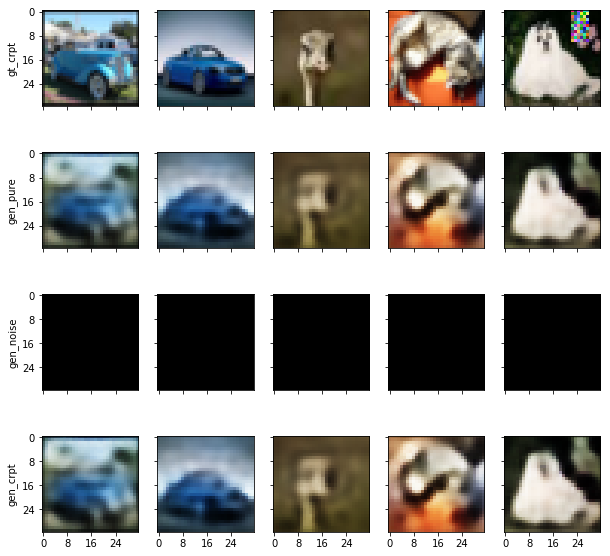

In [14]:
test_disp_idx = np.random.randint(FLAGS.img_num, size=n_plot)
test_gt_pure = np.copy(np.take(cifar10_test_img, test_disp_idx, axis=0))    # (n_plot, 3072) fixed
test_gt_noise = noise_batch(5)    # random noise
test_gt_crpt = occl(test_gt_pure,test_gt_noise)   # corrupted image
test_gt_feeds = {ph_crpt: test_gt_crpt}
test_gen_pure, test_gen_noise, test_gen_crpt = sess.run([core_gen, shell2_gen, full_gen], \
                                                        feed_dict=test_gt_feeds)

# plotting results from testing data
fig, axes = plt.subplots(nrows=4, ncols=n_plot, figsize=(10,2*n_plot))   # displaying 4*n_plot images
plt.setp(axes, xticks=np.arange(0,31,8), yticks=np.arange(0,31,8)) 
for k in range(n_plot):
#     test_disp_gt_crpt = np.reshape(test_gt_crpt[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
    axes[0, k].imshow(test_gt_crpt[k])   
    axes[0, k].set(ylabel='gt_crpt')
    axes[0, k].label_outer()

#     test_disp_gen_pure = np.reshape(test_gen_pure[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
    axes[1, k].imshow(test_gen_pure[k])   
    axes[1, k].set(ylabel='gen_pure')
    axes[1, k].label_outer()           

#     test_disp_gen_noise = np.reshape(test_gen_noise[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
    axes[2, k].imshow(test_gen_noise[k])   
    axes[2, k].set(ylabel='gen_noise')
    axes[2, k].label_outer()

#     test_disp_gen_crpt = np.reshape(test_gen_crpt[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
    axes[3, k].imshow(test_gen_crpt[k])   
    axes[3, k].set(ylabel='gen_crpt')
    axes[3, k].label_outer()
